Import some needed packages

In [1]:
from scipy.stats import norm
import numpy as np
import random, re
import matplotlib.pyplot as plt

Now I need to set up the basic information from KenPom to calculate win probabilities, etc. I need four pieces of data from KenPom: adjusted efficiency margin for each team (AdjEM), and the adjusted tempo for each team (AdjT). AdjEM measures the point differential expected if a team were to play the "average" team over 100 possessions. Adjusted tempo is the average number of possessions by a team over a 40 minute game. I then calculate the point differential expected when team A plays team B over 40 minutes.

In [2]:
# Purdue @ Michigan on 12/9/17
kpEMa, kpEMb = 27.53, 18.02
kpTa, kpTb = 69.8, 64.3
homeadv = 3.5
# ratio of number of expected possesions to 200 possession gam
kpEMtempo = (kpTa + kpTb)/200.0
# Number of points A should win by on neutral floor
kpEMdiffn = (kpEMa - kpEMb)*kpEMtempo
# Number of points A should win by on oponents floor
kpEMdiff = (kpEMa - kpEMb)*kpEMtempo - homeadv


print 'Nueutral Site:', kpEMdiffn
print 'Away Game:', kpEMdiff

Nueutral Site: 6.376455
Away Game: 2.876455


So for this game, Purdue is expected to win by ~2.9 points.  You can think of this as if the game were played many many times, Purdue on average would win by this margin. So now we need to convert this into an actual probability of a team winning.  For this we need to assume some scoring standard deviation.  I.e., if you play the game many times, the average deviation from the expected point differential from above. 

We can visualize this information by using a typical bell cure (normal distribution). The important part here is the standard deviation. The variable “kpEMdiff” is how many points team A is favored by. If this number is negative, then team B would be favored. The zero point is where it switches from team A winning to team B winning. The area under the curve is 1.0, and the red shaded area represents the probability that team B would win, and the blue area represents the probability that team B would win. What is plotted is the probability density function (pdf).



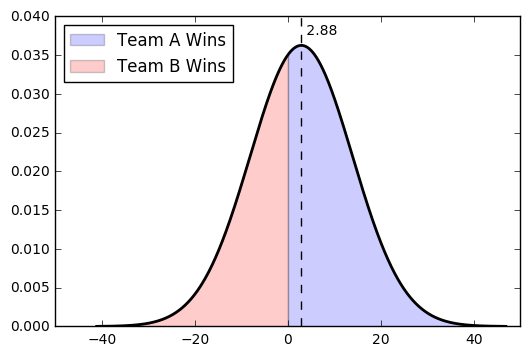

In [3]:
# assume a standard deviation
stdev = 11

# set up the min and max x-values
x = np.arange(kpEMdiff - 4.0*stdev, kpEMdiff + 4.0*stdev, 0.01)
y = norm.pdf(x, kpEMdiff, stdev) 
plt.plot(x,y, color='k', lw=2)
plt.fill_between(x,0,y, where=x >= 0, facecolor='blue', alpha=0.2,label='Team A Wins')
plt.fill_between(x,0,y, where=x <= 0, facecolor='red', alpha=0.2,label='Team B Wins')
plt.axvline(kpEMdiff, c='k',ls='--')
plt.annotate('{0:5.2f}'.format(kpEMdiff),xy=(1.05*kpEMdiff,1.04*y.max()))
plt.legend(loc=2)
plt.show()

There is a function that defines the areas under the curve, i.e., the probabilities directly, which is called the cumulative density function (CDF). We can use this CDF directly to calculate the probability of team A or team B winning.

In [4]:
teamBprob = norm.cdf(0, kpEMdiff, stdev)
teamAprob = 1 - teamBprob

print 'Team A (Purdue):   {0:6.4f}\nTeam B (Michigan): {1:6.4f}'.format(teamAprob, teamBprob)

Team A (Purdue):   0.6031
Team B (Michigan): 0.3969


To do the entire schedule for a team, a couple of simple fucntions will make it easier.  A fucntion to load the data from KenPom's site, a fucntion to calculation the probabilities, and then a fucntion to pick a winner based on the probabilites using a random number between 0 and 1. 

In [5]:
# load a text version of the kenpom data and creat a dictionary
def loadkp(fname):
    keys = 'Rank        Team    Conf    W-L     AdjEM   AdjO    AdjD    AdjT    Luck    SOSAdjEM        SOSOppO SOSOppD NCSOSAdjEM'.split()
    f = open(fname).readlines()
    kpd = {}
    for line in f:
        lsp = line.split('\t')
        if 'Strength' in lsp[0] or 'Rank' in lsp[0]: pass
        else:
            datanorank =  [lsp[i] for i in [0,1,2,3,4,5,7,9,11,13,15,17,19]]
            datanorank[1] = re.split('(\d+)',datanorank[1])[0].strip()
            teamd = dict(zip(keys,datanorank))
            kpd[datanorank[1]] = teamd
    return kpd

# function to calculate kenpom probabilities. a is away team, b is home team. 
def kpprob(a,b,kpd,std=7,homea=0):
    adjemdiff = ((float(kpd[a]['AdjEM']) - float(kpd[b]['AdjEM']))*
                (float(kpd[a]['AdjT']) + float(kpd[b]['AdjT']))/200.0) - homea
    bprob = norm.cdf(0,adjemdiff,std)
    aprob = 1.0-bprob
    return aprob,bprob,adjemdiff

# pick a winner base on the above kenpom probability fucntion
def pickw(pfunc,kpd,g,**kwargs):
    if random.random() <= pfunc(g[0].strip(),g[1].strip(),kpd,**kwargs)[0]: return g[0].strip()
    else: return g[1].strip()

In [6]:
# load the kenpom data - I've just copied and pasted from the website 
# and done a little formatting. 
# valid afternoon of 1/8/2018
kpd = loadkp('kp18.txt')

Below is your teams schedule.  If you want, just copy and paste your schedule in here.  Team names would have to match the formatting the KenPom uses.  First team is away time, second team is away.  Teams are separated by commas.

In [9]:
# set up purdue's remaining regular season schedule
sct = '''Purdue, Rutgers
Ohio St., Purdue
Purdue, Michigan St.
Purdue, Wisconsin
Penn St., Purdue
Purdue, Illinois
Minnesota, Purdue'''.split('\n')

sc = [val.split(',') for val in sct]

myt = 'Purdue'

In [10]:
allprobs = []
# loop through all the games and store each probability.  
for g in sc:
    teams = g[0].strip(),g[1].strip()
    pa,pb,expd = kpprob(teams[0],teams[1],kpd,std=11,homea=3)
    probmyteam = [pa,pb][teams.index(myt)]
    print teams, probmyteam, [expd, -1*expd][teams.index(myt)]
    allprobs.append(probmyteam)

# probability of winning all is the product of all probabilities
# probability of losing all games is the product of (1-p) values
winall = 100*np.prod(np.array(allprobs))
loseall = 100*np.prod(1.0-np.array(allprobs))

print 'Win all:', winall
print 'Lose all:', loseall



('Purdue', 'Rutgers') 0.931888658889 16.390065
('Ohio St.', 'Purdue') 0.80105318332 9.29928
('Purdue', 'Michigan St.') 0.487518770177 -0.3442
('Purdue', 'Wisconsin') 0.866838363588 12.227265
('Penn St.', 'Purdue') 0.914179297161 15.036435
('Purdue', 'Illinois') 0.887808632611 13.36452
('Minnesota', 'Purdue') 0.958321198525 19.04681
Win all: 24.5367299114
Lose all: 3.71090847438e-05


Now figuring out the probability that a team will lose 1, 2, 3, etc., games, is much more complicated.  You'd would have to loop over all remaining possibilities (2^14 for Purdue) then do some more math.  Its easier to just simulate a bunch of seasons and add up the results to get an approximate answer.  This shit is all approximate anyway.  

In [10]:
# Simulate a single season to make sure things are working correctly. 
# Results Looks about right
[pickw(kpprob,kpd,g,std=11,homea=3.5) for g in sc]

['Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue',
 'Purdue']

In [11]:
# Now simulate the season some number of times (nr)
# nr is number of times to run the remaining season
nr = 100000
res = []
for n in range(nr):
    res.append([pickw(kpprob,kpd,g,std=11,homea=3.5) for g in sc])

In [12]:
# Count the total numebr of wins of my team for each season. 
ws = []
for s in res:
    w = s.count(myt)
    ws.append(w)
# Count the number of times a number of wins happen
nw = []
for n in range(0,len(sc)+1,1):
    nw.append(ws.count(n))
print 'Num wins   ',range(0,len(sc)+1,1)
print 'Num Seasons',nw


Num wins    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Num Seasons [0, 0, 0, 3, 29, 407, 2622, 10990, 28740, 38784, 18425]


In [13]:
puprob = 100*np.array(nw)/float(nr)
pugp = zip(range(0,len(sc)+1,1), puprob)
print 'Num W   Probability'
for val in pugp:
    print '{0}\t{1}'.format(*val)
# print 'Probability',100*np.array(nw)/float(nr)

Num W   Probability
0	0.0
1	0.0
2	0.0
3	0.003
4	0.029
5	0.407
6	2.622
7	10.99
8	28.74
9	38.784
10	18.425


So looks like Purdue has about a 2% chance of going undeafeated, based on the assumed standard deviation of 11 and home court advantage of 3.5 points

In [13]:
# Lets check IU...hehe
sct = '''Michigan St., Indiana
Indiana, Maryland
Illinois, Indiana
Purdue, Indiana
Indiana, Ohio St.
Michigan St., Indiana
Indiana, Rutgers
Minnesota, Indiana
Illinois, Indiana
Indiana, Iowa
Indiana, Nebraska
Ohio St., Indiana'''.split('\n')

sc = [val.split(',') for val in sct]

myt = 'Indiana'

In [14]:
nr = 100000
res = []
for n in range(nr):
    res.append([pickw(kpprob,kpd,g,std=7,homea=3) for g in sc])

In [15]:
ws = []
for s in res:
    w = s.count(myt)
    ws.append(w)
# Count the number of times a number of wins happen
nw = []
for n in range(0,len(sc)+1,1):
    nw.append(ws.count(n))
print 'Num wins   ',range(0,len(sc)+1,1)
print 'Num Seasons',nw

Num wins    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Num Seasons [796, 5270, 15569, 25824, 25847, 16705, 7249, 2265, 410, 56, 9, 0, 0, 0, 0]


In [16]:
iuprob = 100*np.array(nw)/float(nr)
iugp = zip(range(0,len(sc)+1,1), iuprob)
print 'Num W   Probability'
for val in iugp:
    print '{0}\t{1}'.format(*val)
# print 'Probability',100*np.array(nw)/float(nr)

Num W   Probability
0	0.796
1	5.27
2	15.569
3	25.824
4	25.847
5	16.705
6	7.249
7	2.265
8	0.41
9	0.056
10	0.009
11	0.0
12	0.0
13	0.0
14	0.0


In [17]:
import pandas as pd
d = {'Purdue':dict(pugp),'Indiana':dict(iugp)}

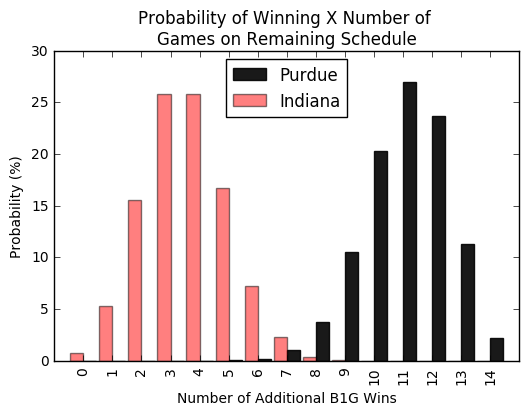

In [19]:
df = pd.DataFrame(d)

fig = plt.figure() 
ax = fig.add_subplot(111) 

width = 0.45

df.Purdue.plot(kind='bar', color='k', ax=ax, width=width, position=0,alpha=0.9)
df.Indiana.plot(kind='bar', color='r', ax=ax, width=width, position=1,alpha=0.5)

plt.xlabel('Number of Additional B1G Wins')
plt.ylabel('Probability (%)')
plt.title('Probability of Winning X Number of \nGames on Remaining Schedule')
plt.legend(loc='best')
plt.xlim(-1,len(sc)+1)
plt.show()
plt.close()